### Prueba de evaluación 2
### Parte 1

### Carlos Eduardo Gómez Fandiño

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as rq
import seaborn as sns
# import pandas.io.data as web # para importar info de Yahoo, google
import h5py
import time
%matplotlib inline

1.En una primera versión, haremos un script en Python que simplemente lea los precios
en diferentes monedas fiat (tomar solamente tres, por ejemplo, USD, EUR y JPY) de 1
BTC (por ejemplo, en intervalos de 1 minuto o similar), que busque los tipos de
intercambio entre algunas de las monedas en otro servicio REST2 y obtenga las
oportunidades de compra/venta con arbitraje como la del ejemplo anterior. Nótese que
los precios de compra y venta son en general diferentes.

In [3]:
currencies = []
count = 0
divisas = ['USD','EUR','JPY']
while count < 5: #Hasta un maximo de 5 segundo de streaming
#while True: # para interrumpit oprimir ii
    r = rq.get('https://blockchain.info/es/ticker')
    
    currencies = {x: r.json()[x] for x in r.json() if x in divisas}
    print currencies

    time.sleep(1) # obtencion de la data cada 1 segundo.
    count += 1 

{u'JPY': {u'sell': 132670.63, u'last': 132669.51, u'symbol': u'\xa5', u'buy': 132636.97, u'15m': 132669.51}, u'USD': {u'sell': 1182.3, u'last': 1182.29, u'symbol': u'$', u'buy': 1182, u'15m': 1182.29}, u'EUR': {u'sell': 1117.01, u'last': 1117, u'symbol': u'\u20ac', u'buy': 1116.73, u'15m': 1117}}
{u'JPY': {u'sell': 132792.94, u'last': 132674, u'symbol': u'\xa5', u'buy': 132670.63, u'15m': 132674}, u'USD': {u'sell': 1183.39, u'last': 1182.33, u'symbol': u'$', u'buy': 1182.3, u'15m': 1182.33}, u'EUR': {u'sell': 1118.04, u'last': 1117.04, u'symbol': u'\u20ac', u'buy': 1117.01, u'15m': 1117.04}}
{u'JPY': {u'sell': 132670.63, u'last': 132669.51, u'symbol': u'\xa5', u'buy': 132636.97, u'15m': 132669.51}, u'USD': {u'sell': 1182.3, u'last': 1182.29, u'symbol': u'$', u'buy': 1182, u'15m': 1182.29}, u'EUR': {u'sell': 1117.01, u'last': 1117, u'symbol': u'\u20ac', u'buy': 1116.73, u'15m': 1117}}
{u'JPY': {u'sell': 132920.87, u'last': 132674, u'symbol': u'\xa5', u'buy': 132671.75, u'15m': 132674}, 

precios de una Bitcoin en el mercado

In [4]:
bitcoin_t_df= pd.DataFrame(currencies).T
bitcoin_t_df

,15m,buy,last,sell,symbol
EUR,1117,1116.73,1117,1117.01,€
JPY,132670,132637,132670,132671,¥
USD,1182.29,1182,1182.29,1182.3,$


### Base Euro

precios de las divisas en base al Euro

In [5]:
cols = ['EUR','JPY','USD']
cols2 = 'EUR'
eur_pair = rq.get('http://api.fixer.io/latest')
eur_pair_df = pd.read_json(eur_pair.text)
eur_pair_df = eur_pair_df.loc[cols,:]

eur_pair_df.loc[cols2] = ['EUR',eur_pair_df.loc['USD','date'],1]

eur_pair_df

,base,date,rates
EUR,EUR,2017-02-27,1.0000
JPY,EUR,2017-02-27,118.8700
USD,EUR,2017-02-27,1.0587


### Analisis Arbitraje para las divisas EUR, USD, JPY

Suponemos que tenemos 1 Bitcoin y queremos simular las opciones que tenemos para hacer arbitraje con las tres divisas mencionadas:

In [6]:
simulacion1 = bitcoin_t_df.loc[:,'buy']
print 'Por 1 BTC obtenemos:', '\n' , simulacion1

Por 1 BTC obtenemos: 
EUR    1116.73
JPY     132637
USD       1182
Name: buy, dtype: object


Ahora simularemos que compraremos euros en cada una de las divisas

In [7]:
compraEUR = simulacion1 / eur_pair_df.loc[:,'rates']
compraEUR

EUR    1116.73
JPY    1115.82
USD    1116.46
dtype: object

posterior mente vamos a comprarun BTC con los euros comprados con las divisas vendidas en el punto anterior

In [8]:
cols = ['EUR']
BTC_EUR = bitcoin_t_df.loc[cols, 'sell']
BTC_EUR

EUR    1117.01
Name: sell, dtype: object

In [9]:
arbitrajeEUR = compraEUR / bitcoin_t_df.loc['EUR','sell']
arbitrajeEUR

EUR    0.999749
JPY     0.99893
USD    0.999511
dtype: object

In [10]:
for i in range(0,3,1):
    print 'Vendiendo la BTC a ',arbitrajeEUR.index[i],' para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de:',arbitrajeEUR[i]-1,'BTC'

Vendiendo la BTC a  EUR  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -0.000250669197232 BTC
Vendiendo la BTC a  JPY  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -0.00106951191665 BTC
Vendiendo la BTC a  USD  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -0.000489174296978 BTC


#### Decuando al resultado anterior, decimos que hay arbitraje cuando el valor es > 1, lo cual luego de realizar todas estas operaciones de compra y venta obtenemos un resultado sin riesgo (bajo el supuesto que no hay cobro de comisiones u otros cargos administrativos)

### Ahora haremos el mismo analisis anterior pero con base en Dolar USD

In [11]:
cols = ['EUR','JPY','USD']
cols2 = 'USD'
usd_pair = rq.get('http://api.fixer.io/latest?base=USD') #Estos precios se actualizan dia a dia.
usd_pair_df = pd.read_json(usd_pair.text)
usd_pair_df = usd_pair_df.loc[cols,:]

usd_pair_df.loc[cols2] = ['USD',usd_pair_df.loc['EUR','date'],1]

usd_pair_df

,base,date,rates
EUR,USD,2017-02-27,0.94455
JPY,USD,2017-02-27,112.28000
USD,USD,2017-02-27,1.00000


Para esta ejercicio Vendemos 1 BTC y simulamos comprar cada una de las monedas que se muestran a continuacion:

In [12]:
simulacion2 = bitcoin_t_df.loc[:,'buy']
print 'Por 1 BTC obtenemos:', '\n' , simulacion2

Por 1 BTC obtenemos: 
EUR    1116.73
JPY     132637
USD       1182
Name: buy, dtype: object


Ahora vamos a comprar Dolares USD con las divisas recibidad anteriormente.

In [13]:
cols = ['USD','EUR','JPY']
ind = ['USD']
compraUSD = simulacion2 / usd_pair_df.loc[:,'rates']
compraUSD

EUR    1182.29
JPY    1181.31
USD       1182
dtype: object

Precio Venta de 1 BTC

In [14]:
cols = ['USD']
BTC_USD = bitcoin_t_df.loc[cols,'sell']
BTC_USD

USD    1182.3
Name: sell, dtype: object

Posteriormente vamos a volver a comprar 1 BTC con los dolares obtenido en cada una de las simulaciones mostradas anteriormente.

In [15]:
arbitrajeUSD = compraUSD / bitcoin_t_df.loc['USD','sell']
arbitrajeUSD

EUR     0.99999
JPY    0.999159
USD    0.999746
dtype: object

Rentbailidad en BTC

In [16]:
for i in range(0,3,1):
    print 'Vendiendo la BTC a ',arbitrajeUSD.index[i],' para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de:',arbitrajeUSD[i]-1, 'BTC'

Vendiendo la BTC a  EUR  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -1.02664764938e-05 BTC
Vendiendo la BTC a  JPY  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -0.000841243997942 BTC
Vendiendo la BTC a  USD  para luego comprar USD y posterior mente recomprar la BTC. Se obtuvo una rentabilidad por 1 BTC de: -0.000253742704897 BTC


#### Decuando al resultado anterior, decimos que hay arbitraje cuando el valor es > 1, lo cual luego de realizar todas estas operaciones de compra y venta obtenemos un resultado sin riesgo (bajo el supuesto que no hay cobro de comisiones u otros cargos administrativos)

### 2.Basándonos en las ideas de esa primera versión, modificar el script para que grabe en disco en un fichero HDF5 las series temporales de diferencias entre pares de monedas como la descrita en el ejemplo anterior (todas, positivas o negativas). Después, en un Notebook se leerán las series del fichero, obteniendo los máximos y mínimos y dibujando las series para intentar comparar los diferentes pares de monedas. El tiempo será el de la ejecución de cada iteración del script.

### Se guardan los data frames serieTiempoDivisas en serieTiempo.h5

In [17]:
import datetime
import oandapy
from forex_python.converter import CurrencyRates

In [18]:
divisas = ['EUR','JPY','USD']
bitcoin_pairs = []
currentTime = []
forex_EUR_USD = []
forex_EUR_JPY = []
bitcoin_pairs += bitcoin_pairs
forex_EUR_USD += forex_EUR_USD
forex_EUR_JPY += forex_EUR_JPY

In [19]:
c = CurrencyRates()
c.get_rates('EUR')['USD']
        

1.0587

In [21]:
count = 0 # con este while lo que hacemos es que tenga un limite de streming y no sea infinito sin embargo podemos colocarlos
BTC1_USD = 1 # BTC Nominal actual con comision USD
BTC2_USD = 1 # BTC Nominal actual sin comision JPY
BTC1_JPY = 1 # BTC Nominal actual con comision JPY
BTC2_JPY = 1 # BTC Nominal actual sin comision JPY
#Inicializando la variable PyG en 1.
PyG1_USD = [1]
PyG2_USD = [1]
PyG1_JPY = [1]
PyG2_JPY = [1]

# infinito y poner el while true:
#while True: # para cancelarlo pulsar ii(interrumpe kernel) ó 00(resetea kernel)
while count < 15: # para este caso solo vamos a obtener el streming de cada segundo por 10 segundos. 

    #API OANDA where I ask for forex prices, in this case EUR_USD
    oanda = oandapy.API(environment="practice", access_token="b17d20b871353dfc9f94314903dbbb16-664b54be0210711911a195749f981e0f")
    response_EUR_USD = oanda.get_prices(instruments="EUR_USD")
    response_EUR_JPY = oanda.get_prices(instruments="EUR_JPY")

    forex_EUR_USD.append(response_EUR_USD.get("prices"))
    forex_EUR_JPY.append(response_EUR_JPY.get("prices"))
    
    #API Blockchain.info, Where I ask for BTC prices
    r = rq.get('https://blockchain.info/es/ticker')
    
    currencies = {x: r.json()[x] for x in r.json() if x in divisas}
    
    #print currencies
#     run_time = 1
    bitcoin_pairs.append(currencies)
    
    # Transaction
    
    # BTC - EUR - USD - BTC con comision
    if BTC1_USD > 0:
        BTC1_USD = (BTC1_USD * currencies['EUR']['buy']) * forex_EUR_USD[0][0]['bid'] / currencies['USD']['sell']
        PyG1_USD.append(BTC1_USD)

    
#     # BTC - EUR - USD - BTC sin comision
    if BTC2_USD > 0:
        c = CurrencyRates()
        BTC2_USD = (BTC2_USD * currencies['EUR']['buy']) * c.get_rates('EUR')['USD'] / currencies['USD']['sell']
        PyG2_USD.append(BTC2_USD)
        
    # BTC - EUR - JPY - BTC con comision
    if BTC1_JPY > 0:
        BTC1_JPY = (BTC1_JPY * currencies['EUR']['buy']) * forex_EUR_JPY[0][0]['bid'] / currencies['JPY']['sell']
        PyG1_JPY.append(BTC1_JPY)

    
#     # BTC - EUR - JPY - BTC sin comision  #API Acutalmente dañada
    if BTC2_JPY > 0:
        c = CurrencyRates()
        BTC2_JPY = (BTC2_JPY * currencies['EUR']['buy']) * c.get_rates('EUR')['JPY'] / currencies['JPY']['sell']
        PyG2_JPY.append(BTC2_JPY)

    
    # Creadting a Datetime
    currentTime.append(str(datetime.datetime.now()))
    time.sleep(1)
    count = count + 1
#     j += 1
    
print 'Finished'
#si queremos mas stremings, debemos de ejecutar este mismo codigo nuevamente para que tenegamos nuevos valores.

Finished


## P&G en BTC con Comisiones - Transaction: BTC - EUR - USD - BTC

#### En esta operacion Vendimos un BTC y compramos EUR, luego vendimos los EUR para comprar USD, por ultimo vendemos los USD para comprar nuevamente un BTC. Esta operacion la hacemos con comisiones.

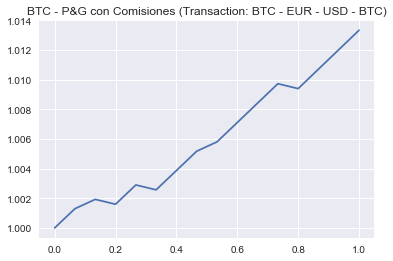

In [22]:
plt.plot(np.linspace(0,1,len(PyG1_USD)), PyG1_USD)
plt.title('BTC - P&G con Comisiones (Transaction: BTC - EUR - USD - BTC)')

En este caso, aun pagando comisiones, tenemos oportunidades de arbitraje.

## P&G en BTC sin Comisiones - Transaction: BTC - EUR - USD - BTC

#### En esta operacion Vendimos un BTC y compramos EUR, luego vendimos los EUR para comprar USD, por ultimo vendemos los USD para comprar nuevamente un BTC. Esta operacion la hacemos sin comisiones.

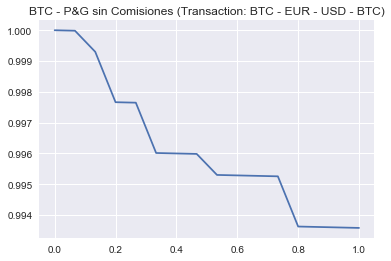

In [23]:
plt.plot(np.linspace(0,1,len(PyG2_USD)), PyG2_USD)
plt.title('BTC - P&G sin Comisiones (Transaction: BTC - EUR - USD - BTC)')

En este caso, aun sin pagar comisiones, tenemos perdidas.

## P&G en BTC con Comisiones - Transaction: BTC - EUR - JPY - BTC

#### En esta operacion Vendimos un BTC y compramos EUR, luego vendimos los EUR para comprar JPY, por ultimo vendemos los JPY para comprar nuevamente un BTC. Esta operacion la hacemos con comisiones.

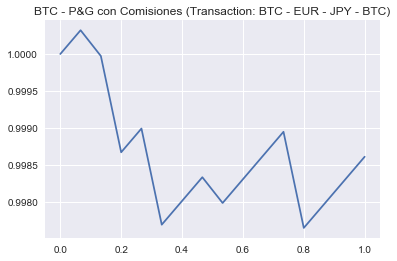

In [24]:
plt.plot(np.linspace(0,1,len(PyG1_JPY)), PyG1_JPY)
plt.title('BTC - P&G con Comisiones (Transaction: BTC - EUR - JPY - BTC)')

En este Caso aun pagando comisiones, podemos tener rentabilidad por las ineficiencias del mercado, permitiendonos asi poder hacer arbitraje, sin embargo nuestro P&G es negativo.

## P&G en BTC sin Comisiones - Transaction: BTC - EUR - JPY - BTC

#### En esta operacion Vendimos un BTC y compramos EUR, luego vendimos los EUR para comprar JPY, por ultimo vendemos los JPY para comprar nuevamente un BTC. Esta operacion la hacemos sin comisiones.

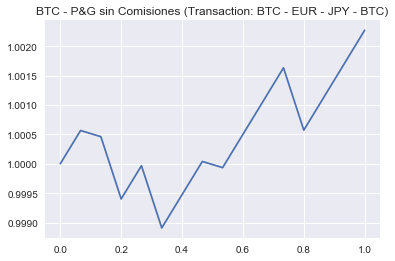

In [25]:
plt.plot(np.linspace(0,1,len(PyG2_JPY)), PyG2_JPY)
plt.title('BTC - P&G sin Comisiones (Transaction: BTC - EUR - JPY - BTC)')

Para este caso, a diferencia con el USD, hemos tenido rentabilidaes positivas, sin embargo nuestro riego es mucho mayor, dado que hubo un momento en que estuvimos en negativo, pero despues recupero.

##### Ahora procederemos a guardar las rentabilidades cuando pagamos comisiones en un fichero HDF5, como se mostrara a continuacion:

In [26]:
h5_yield = pd.HDFStore('comisiones.h5','w')

In [27]:
PyG1_JPY_df = pd.DataFrame(data=[currentTime,PyG1_JPY]).T
PyG1_USD_df = pd.DataFrame(data=[currentTime,PyG1_USD]).T
PyG1_JPY_df.rename(columns = {0:'Time', 1:'Yield_JPY'}, inplace=True)
PyG1_USD_df.rename(columns = {0:'Time', 1:'Yield_USD'}, inplace=True)

In [28]:
h5_yield['yield_USD_comision'] = PyG1_USD_df
h5_yield['yield_JPY_comision'] = PyG1_JPY_df

#### Como vemos se muestra que se han almacenado las rentabilidades en el fichero comisiones.h5

In [29]:
print h5_yield
h5_yield.close()

<class 'pandas.io.pytables.HDFStore'>
File path: comisiones.h5
/yield_JPY_comision            frame        (shape->[1,2])
/yield_USD_comision            frame        (shape->[1,2])


In [30]:
bitcoin_EUR_sell = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_EUR_sell.append(bitcoin_pairs[i]['EUR']['sell'])

bitcoin_EUR_buy = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_EUR_buy.append(bitcoin_pairs[i]['EUR']['buy'])
    
bitcoin_USD_sell = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_USD_sell.append(bitcoin_pairs[i]['USD']['sell'])
    
bitcoin_USD_buy = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_USD_buy.append(bitcoin_pairs[i]['USD']['buy'])

bitcoin_JPY_sell = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_JPY_sell.append(bitcoin_pairs[i]['JPY']['sell'])
    
bitcoin_JPY_buy = []
for i in range(0,len(bitcoin_pairs),1):
    bitcoin_JPY_buy.append(bitcoin_pairs[i]['JPY']['buy'])
    
#print len(bitcoin_EUR_sell)
#print len(bitcoin_EUR_buy)
#print len(bitcoin_USD_sell)
#print len(bitcoin_USD_buy)
#print len(bitcoin_JPY_sell)
#print len(bitcoin_JPY_buy)


Creamos los dataframes de cada una de las paridades con base en BTC

In [31]:
bitcoin_series = pd.DataFrame(data=[bitcoin_EUR_sell,bitcoin_EUR_buy,bitcoin_USD_sell,bitcoin_USD_buy,bitcoin_JPY_sell,
                                   bitcoin_JPY_buy]).T
bitcoin_series.rename(columns={0:'EUR_sell',1:'EUR_buy',2:'USD_sell',3: 'USD_buy',4:'JPY_sell',5:'JPY_buy',6:'EUR_USD_ask'},inplace=True)
bitcoin_series.index = currentTime
bitcoin_EUR_sell = pd.DataFrame(bitcoin_EUR_sell, columns=['EUR_sell'])
bitcoin_EUR_buy = pd.DataFrame(bitcoin_EUR_buy, columns=['EUR_buy'])
bitcoin_USD_sell = pd.DataFrame(bitcoin_USD_sell, columns=['USD_sell'])
bitcoin_USD_buy = pd.DataFrame(bitcoin_USD_buy, columns=['USD_buy'])
bitcoin_JPY_sell = pd.DataFrame(bitcoin_JPY_sell, columns=['JPY_sell'])
bitcoin_JPY_buy = pd.DataFrame(bitcoin_JPY_buy, columns=['JPY_buy'])
# bitcoin_JPY_buy = pd.DataFrame(bitcoin_JPY_buy, columns=['JPY_buy'])
bitcoin_series.head()

,EUR_sell,EUR_buy,USD_sell,USD_buy,JPY_sell,JPY_buy
2017-02-28 15:52:10.634000,1117.01,1116.73,1182.30,1182.00,132670.63,132636.97
2017-02-28 15:52:12.466000,1119.12,1117.02,1184.53,1182.31,132920.87,132671.75
2017-02-28 15:52:26.072000,1117.01,1116.73,1182.30,1182.00,132670.63,132636.97
2017-02-28 15:52:28.114000,1118.04,1117.01,1183.39,1182.30,132792.94,132670.63
2017-02-28 15:52:30.089000,1119.12,1117.02,1184.53,1182.31,132920.87,132671.75


Ahora procedemos a poner las fechas de consulta de cada uno de los streamings realizados en los pasos anteriores.

In [32]:
bitcoin_EUR_sell.index = currentTime
bitcoin_EUR_buy.index = currentTime
bitcoin_USD_sell.index= currentTime
bitcoin_USD_buy.index = currentTime
bitcoin_JPY_sell.index = currentTime
bitcoin_JPY_buy.index = currentTime

Creamos el fichero HDF5

In [33]:
h5 = pd.HDFStore('serieTiempo.h5','w')

Luego de crear dicho dichero, guardamos cada uno de los df en dicho fichero.

In [34]:
h5['BTC_EUR_sell'] = bitcoin_EUR_sell
h5['BTC_EUR_buy'] = bitcoin_EUR_buy
h5['BTC_USD_sell'] = bitcoin_USD_sell
h5['BTC_USD_buy'] = bitcoin_USD_buy
h5['BTC_JPY_sell'] = bitcoin_JPY_sell
h5['BTC_JPY_buy'] = bitcoin_JPY_buy
h5['full_Series_BTC'] = bitcoin_series

Mostramos que se guardaron los df en el fichero serieTiempo.h5, y posteriormente cerramos el fichero

In [35]:
print h5
h5.close()
#h5.open()

<class 'pandas.io.pytables.HDFStore'>
File path: serieTiempo.h5
/BTC_EUR_buy                frame        (shape->[17,1])
/BTC_EUR_sell               frame        (shape->[17,1])
/BTC_JPY_buy                frame        (shape->[17,1])
/BTC_JPY_sell               frame        (shape->[17,1])
/BTC_USD_buy                frame        (shape->[17,1])
/BTC_USD_sell               frame        (shape->[17,1])
/full_Series_BTC            frame        (shape->[17,6])


In [36]:
print bitcoin_series.index
print bitcoin_series.columns

Index([u'2017-02-28 15:52:10.634000', u'2017-02-28 15:52:12.466000',
       u'2017-02-28 15:52:26.072000', u'2017-02-28 15:52:28.114000',
       u'2017-02-28 15:52:30.089000', u'2017-02-28 15:52:32.084000',
       u'2017-02-28 15:52:34.126000', u'2017-02-28 15:52:36.177000',
       u'2017-02-28 15:52:38.200000', u'2017-02-28 15:52:40.178000',
       u'2017-02-28 15:52:42.156000', u'2017-02-28 15:52:44.140000',
       u'2017-02-28 15:52:50.135000', u'2017-02-28 15:52:52.101000',
       u'2017-02-28 15:52:54.083000', u'2017-02-28 15:52:56.056000',
       u'2017-02-28 15:52:58.047000'],
      dtype='object')
Index([u'EUR_sell', u'EUR_buy', u'USD_sell', u'USD_buy', u'JPY_sell',
       u'JPY_buy'],
      dtype='object')


#### EUR Time Series (buy and sell)

In [37]:
bitcoin_series.iloc[:,0:2].head()

,EUR_sell,EUR_buy
2017-02-28 15:52:10.634000,1117.01,1116.73
2017-02-28 15:52:12.466000,1119.12,1117.02
2017-02-28 15:52:26.072000,1117.01,1116.73
2017-02-28 15:52:28.114000,1118.04,1117.01
2017-02-28 15:52:30.089000,1119.12,1117.02


### Graficas BTC_EUR (buy and sell)

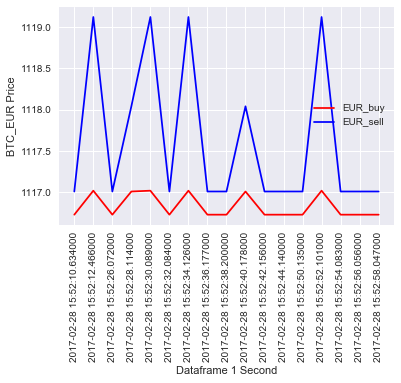

In [38]:
x = range(0,len(bitcoin_series))
xDate = bitcoin_series.index
plt.xticks(x, xDate, rotation = 90)
plt.plot(x, bitcoin_series['EUR_buy'], 'r-', x, bitcoin_series['EUR_sell'], 'b-')
plt.ylim()
plt.ylabel('BTC_EUR Price')
plt.xlabel('Dataframe 1 Second')
plt.legend(['EUR_buy','EUR_sell'])

#### USD Time Series

In [39]:
bitcoin_series.iloc[:,2:4].head()

,USD_sell,USD_buy
2017-02-28 15:52:10.634000,1182.30,1182.00
2017-02-28 15:52:12.466000,1184.53,1182.31
2017-02-28 15:52:26.072000,1182.30,1182.00
2017-02-28 15:52:28.114000,1183.39,1182.30
2017-02-28 15:52:30.089000,1184.53,1182.31


### Graficas BTC_USD (buy and sell)

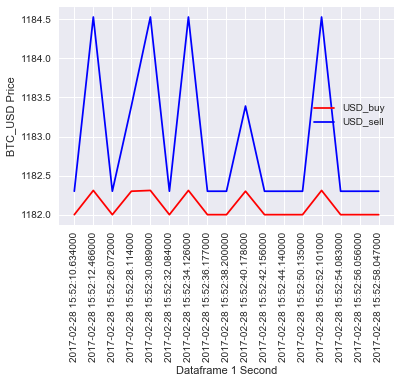

In [40]:
x = range(0,len(bitcoin_series))
xDate = bitcoin_series.index
plt.xticks(x, xDate, rotation = 90)
plt.plot(x,bitcoin_series['USD_buy'], 'r-', x, bitcoin_series['USD_sell'], 'b-')
plt.ylim()
plt.ylabel('BTC_USD Price')
plt.xlabel('Dataframe 1 Second')
plt.legend(['USD_buy','USD_sell'])

#### JPY Time Series

In [41]:
bitcoin_series.iloc[:,4:6].head()

,JPY_sell,JPY_buy
2017-02-28 15:52:10.634000,132670.63,132636.97
2017-02-28 15:52:12.466000,132920.87,132671.75
2017-02-28 15:52:26.072000,132670.63,132636.97
2017-02-28 15:52:28.114000,132792.94,132670.63
2017-02-28 15:52:30.089000,132920.87,132671.75


### Graficas BTC_JPY (buy and sell)

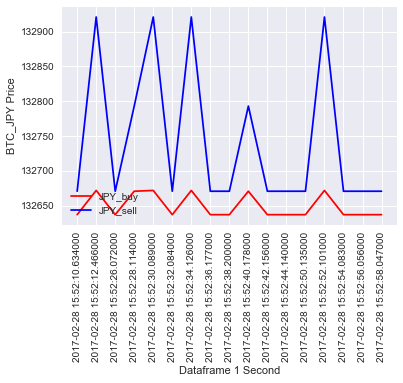

In [42]:
x = range(0,len(bitcoin_series))
xDate = bitcoin_series.index
plt.xticks(x, xDate, rotation = 90)
plt.plot(x,bitcoin_series['JPY_buy'], 'r-', x, bitcoin_series['JPY_sell'], 'b-')
plt.ylim()
plt.ylabel('BTC_JPY Price')
plt.xlabel('Dataframe 1 Second')
plt.legend(['JPY_buy','JPY_sell'], loc = 'lower left')

In [43]:
print 'A continuacion se muestran los valores máximos por cada divisa (tanto en sell y en buy) con base en BTC: '
print bitcoin_series.apply(func=max,axis=0)
print '\n'
print 'A continuacion se muestran los valores mínimos por cada divisa (tanto en sell y en buy) con base en BTC: '
print bitcoin_series.apply(func=min,axis=0)

A continuacion se muestran los valores máximos por cada divisa (tanto en sell y en buy) con base en BTC: 
EUR_sell      1119.12
EUR_buy       1117.02
USD_sell      1184.53
USD_buy       1182.31
JPY_sell    132920.87
JPY_buy     132671.75
dtype: float64


A continuacion se muestran los valores mínimos por cada divisa (tanto en sell y en buy) con base en BTC: 
EUR_sell      1117.01
EUR_buy       1116.73
USD_sell      1182.30
USD_buy       1182.00
JPY_sell    132670.63
JPY_buy     132636.97
dtype: float64


### Para este ejercicio se puede observar que es viable las estrategias de arbitraje sin embargo cabe resaltar que como no se pagan comisiones ni gastos administrativos, deberiasmos para futuros analisis contemplarlos y verificar nuevamente si se producen oportunidades de arbitraje y ver su rentabilidad.

### Parte 2

En esta segunda parte continuaremos con uno de los ejercicios de la PEC1. Concretamente,
intentaremos completar el dataset de los accidentes de aviones con datos que se pueden
encontrar en Internet.
La idea es ampliar el dataset con nuevas columnas, tomando información mediante scraping de
páginas Web u otros métodos de adquisición si se encuentran. Una fuente posible es
Wikipedia:
https://en.wikipedia.org/wiki/Breguet_14
Particularmente, en el cuadro que aparece a la derecha parece haber información semiestructurada.
No obstante, las URL no siguen un esquema de nombrado uniforme en todos los
casos.
Se pide:
- Estudiar el problema de adquisición.
- Enviar el código utilizado para obtener los datos adicionales, de acuerdo a lo
estudiado.
- Enviar un fichero de texto RESUMEN.TXT donde se resuman cuantitativamente los
datos que se han conseguido obtener, qué atributos o variables se han extraído, qué
número de filas de cada atributo.
NOTA: Hay posibilidades más avanzadas para obtener los datos de Wikipedia, como hacer uso
de DBPedia, pero requiere conocimientos adicionales no vistos en clase, por lo que se deja
como alternativa para los estudiantes que quieran estudiarlo.
NOTA: Este ejercicio no tiene solución única, por la casuística de los datos no estructurados.
No se pretende una extracción exhaustiva del 100% de los datos de Wikipedia, sino demostrar
la capacidad que se tiene para obtener datos

In [5]:
import bs4 as bs
import urllib2

In [6]:
airplanes = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv',sep=',')

In [7]:
airplanes.Date = pd.to_datetime(airplanes.Date)
airplanes.head(3)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...


In [8]:
sauce = urllib2.urlopen('https://en.wikipedia.org/wiki/Breguet_14').read()
soup = bs.BeautifulSoup(sauce)

In [9]:
table = soup.table
table

<table class="infobox" style="width:315px;border-spacing:2px;">\n<tr>\n<th colspan="2" style="text-align: center; font-size: large; padding-bottom: 0.3em;">Breguet 14</th>\n</tr>\n<tr>\n<td colspan="2" style="text-align: center;"><a class="image" href="/wiki/File:Breguet_14_Kiew.jpg"><img alt="Breguet 14 Kiew.jpg" data-file-height="324" data-file-width="800" height="122" src="//upload.wikimedia.org/wikipedia/commons/thumb/7/73/Breguet_14_Kiew.jpg/300px-Breguet_14_Kiew.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/7/73/Breguet_14_Kiew.jpg/450px-Breguet_14_Kiew.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/7/73/Breguet_14_Kiew.jpg/600px-Breguet_14_Kiew.jpg 2x" width="300"/></a></td>\n</tr>\n<tr>\n<td colspan="2" style="border-bottom: 1px solid #aaa;text-align:center;">Polish Breguet 14 during the <a class="mw-redirect" href="/wiki/Kiev_Offensive" title="Kiev Offensive">Kiev Offensive</a></td>\n</tr>\n<tr>\n<th>Role</th>\n<td><a href="/wiki/Bomber" title="Bomber">

In [10]:
table_rows = table.find_all('tr')

In [11]:
row = []
row2 = []
for tr in table_rows:
    td = tr.find_all('td')
    th = tr.find_all('th')
    row.extend([i.text for i in td])
    row2.extend([i.text for i in th])
    #print row
    #print row2

In [12]:
df1 = pd.DataFrame(data=[row2[0:len(row)],row[1:len(row)]]).T
#df1[1].shift(-1)[0:9]
df1.rename(columns={0:'caracteristicas',1:'descripcion'})


#pd.read_html('https://en.wikipedia.org/wiki/Breguet_14') #Otra forma de hacerlo pero con pd.read_html
#for df in table:
    #print df

,caracteristicas,descripcion
0,Breguet 14,Polish Breguet 14 during the Kiev Offensive
1,Role,Bomber
2,Manufacturer,Breguet
3,Designer,Marcel Vuillierme
4,First flight,"November 21, 1916"
5,Introduction,1917
6,Primary users,Aéronautique Militaire\nUS Army Air Service\nP...
7,Produced,1916-1928
8,Number built,"ca 7,800"


#### Ahora importaremos toda la informacion relevante de cada avión

Modificaremos cada informacion con respecto a los aviones y cambiaremos los espacios por ('_'), para poder luego pegarlo con la url de wikipedia y asi pueda realizar consultas de cada una avión. sin embargo habrán casos en que los aviones no se encuentre en wikipedia o porque al momento de realizar dichas modificaciones no este esa ruta en Wikipedia.

In [13]:
cols = ['Type']
airplanes_list = np.unique(airplanes[cols])
airplanes_list = airplanes_list[1:len(airplanes_list)]
airplanes_ok = []
for i in range(0,len(airplanes_list),1):
    airplanes_ok.append(airplanes_list[i].replace(' ', '_'))

airplanes_ok[0:10]

['AAC-1_Toucan',
 'AEGK',
 'AT_L98_Carvair',
 'ATR_42-300',
 'ATR-42-300',
 'ATR-72-202',
 'ATR-72-212',
 'Aermacchi_MB-339PAN_(3_aircraft)',
 'Aero_Commander__520',
 'Aero_Commander_500-B']

Ahora realizaremos la consulta de cada avion en la url de wikipedia, para este ejemplo, haremos los primero 100 aviones, puesto que si tomamos todos podriamos generar problemas de ejecucion por rendimiento de la maquina.

Aqui podremos notar cuales son los aviones que no se pudo obtener la informacion

In [74]:
import requests
from bs4 import BeautifulSoup

peticiones = []
names =[]
airplanes_names = []
for j in airplanes_ok[0:100]:
    r = requests.get('https://en.wikipedia.org/wiki/'+str(j))
    if r.status_code == 200:
        soup = BeautifulSoup(r.content,'lxml')
        peticion = soup.find_all('table',{'class':"infobox"})
        peticiones +=(peticion)
        names += [j]
        
        if j == '':
            airplanes_names += ['Nada']
        else:
            airplanes_names += [str(j)]
            
        
        print str(j)+' Downloaded'

Role = []
Manufacturer = []
First_flight = []
Introduction = []
Produced = []
Number_built = []
Name_ = []

for i in peticiones:
    #print type (i)
    rol=None
    if (i.find('th',string='Role') != None):
        rol = i.find('th',string='Role').find_next('td').text

    manu = None
    if (i.find('th',string='Manufacturer') != None):
        manu = i.find('th',string='Manufacturer').find_next('td').text
    
    first = None    
    if (i.find('th',string='First flight')!=None): 
        first = i.find('th',string='First flight').find_next('td').text
    
    intro = None    
    if (i.find('th',string='Introduction')!=None): 
        first = i.find('th',string='Introduction').find_next('td').text
        
    prod = None
    if (i.find('th',string='Produced')!=None): 
        prod = i.find('th',string='Produced').find_next('td').text
    
    numb= None
    if (i.find('th',string='Number built')!=None): 
        numb = i.find('th',string='Number built').find_next('td').text
        
    name_ =None
    if (i.find('td',string='') != None):
        name_ = i.find('td',string='').find_next('th').text

    Role.append(rol)
    Manufacturer.append(manu)
    First_flight.append(first)
    Introduction.append(intro)
    Produced.append(prod)
    Number_built.append(numb)
    Name_.append(name_)

ATR_42-300 Downloaded
ATR-42-300 Downloaded
ATR-72-202 Downloaded
Aero_Commander__520 Downloaded
Aero_Commander_560 Downloaded
Aero_Commander_680 Downloaded
Aero_Commander_681 Downloaded
Aerospatiale_ATR-72 Downloaded
Aerospatiale_Corvette Downloaded
Aerospatiale_Puma Downloaded
Aerospatiale_SA316B Downloaded
Airbus_A-340 Downloaded
Airbus_A300 Downloaded
Airbus_A300-600R Downloaded
Airbus_A300-622R Downloaded
Airbus_A300B2-101 Downloaded
Airbus_A300B2-1C Downloaded
Airbus_A300B2-203 Downloaded
Airbus_A300B4-203 Downloaded
Airbus_A300B4-622R Downloaded
Airbus_A310-304 Downloaded
Airbus_A310-324 Downloaded
Airbus_A320-111 Downloaded
Airbus_A320-211 Downloaded
Airbus_A320-212 Downloaded
Airbus_A320-214 Downloaded
Airbus_A320-231 Downloaded
Airbus_A320-232 Downloaded
Airbus_A330-203 Downloaded
Airbus_A330-321 Downloaded
Airship Downloaded
Airspeed_Oxford Downloaded
Antonov_12 Downloaded
Antonov_12V Downloaded
Antonov_24 Downloaded
Antonov_24B Downloaded
Antonov_28 Downloaded


In [75]:
len(airplanes_names)

37

#### Unificacion de los aviones descargados a un DataFrame

In [69]:
indx = ['Role', 'Manufacturer', 'First_flight', 'Introduction', 'Produced', 'Number_built']
airplane_concat = pd.DataFrame(data=[Role, Manufacturer, First_flight, Introduction, Produced, Number_built],index = indx)
airplane_concat

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
Role,Regional airliner,Regional airliner,Regional airliner,Utility and transport aircraft,Utility and transport aircraft,Utility and transport aircraft,Utility and transport aircraft,Regional airliner,Business jet,Utility helicopter,...,Narrow-body jet airliner,Narrow-body jet airliner,Wide-body jet airliner,Wide-body jet airliner,Training aircraft,Civil and military transport aircraft,Civil and military transport aircraft,Transport aircraft,Transport aircraft,Short-range airliner
Manufacturer,ATR,ATR,ATR,Aero Design and Engineering Company/Aero Comma...,Aero Design and Engineering Company/Aero Comma...,Aero Design and Engineering Company/Aero Comma...,Aero Design and Engineering Company/Aero Comma...,ATR,Aérospatiale,Aérospatiale,...,Airbus,Airbus,Airbus,Airbus,Airspeed Ltd.,Antonov,Antonov,Antonov,Antonov,Antonov
First_flight,3 December 1985,3 December 1985,27 October 1989 (Finnair),October 1952,October 1952,October 1952,October 1952,27 October 1989 (Finnair),16 July 1970,1968,...,18 April 1988 with Air France[2],18 April 1988 with Air France[2],17 January 1994 with Air Inter,17 January 1994 with Air Inter,19 June 1937,1959,1959,1962,1962,1986
Introduction,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Produced,1984–present,1984–present,1988–present,1951-1986,1951-1986,1951-1986,1951-1986,1988–present,1974 - 1977,1968–87,...,1986–present,1986–present,1992–present,1992–present,None,1957–1973,1957–1973,1959–1979,1959–1979,1975–1993
Number_built,"455 (as of January 19, 2017)[1]","455 (as of January 19, 2017)[1]","906 as of January 19, 2017[1]",None,None,None,None,"906 as of January 19, 2017[1]",40,697,...,"7,442 as of 31 January 2017[update][4]","7,442 as of 31 January 2017[update][4]","1,326 as of 31 January 2017[update][2]","1,326 as of 31 January 2017[update][2]","8,586","1,248","1,248","1,367 (including the Chinese Y-7)[1]","1,367 (including the Chinese Y-7)[1]",191


## Parte 3
El sitio Web NOOA del gobierno de EEUU proporciona datasets de datos climáticos a través de
esta página Web:

http://www.ncdc.noaa.gov/cdo-web/datasets

Entre ellos tenemos los datasets “Quality Controlled Local Climatological Data (QCLCD)”
que se describen aquí:

http://www.ncdc.noaa.gov/data-access/land-based-station-data/land-baseddatasets/

quality-controlled-local-climatological-data-qclcd
Entre los datos que se encuentran en los datasets QCLCD están las precipitaciones por años y
estaciones. Por ejemplo, podemos descargar los datasets de aquí:

http://www.ncdc.noaa.gov/orders/qclcd/

Y encontraremos ficheros con datos de precipitaciones como este:

Y encontraremos ficheros con datos de precipitaciones como este:
Wban Number, YearMonthDay, Time, Hourly Precip

03013,19960701,0053,0
03013,19960701,0153,0
03013,19960701,0253,0
03013,19960701,0353,0
03013,19960701,0453,0
…

Opcional: finalmente, se platea el almacenar en el fichero HDF5 los resúmenes mismos
obtenidos y comparar el tiempo de recuperación de esos datos del fichero con el tiempo
tardado en calcularlo.

### Descargamos los archivos .zip de la siguiente web: https://www.ncdc.noaa.gov/orders/qclcd/ (en este caso descargaremos solo los datos para el 2016)

### Ahora descomprimiremos los archivos descargados anteriormente.

In [2]:
import urllib

lista_numeros = ["%.2d" % i for i in range(1,13)]
anio_view = range(2015,2017)

for anio in anio_view:
    for mes in lista_numeros:
        print 'Downloading from: '+'https://www.ncdc.noaa.gov/orders/qclcd/QCLCD'+str(anio)+mes+'.zip'
        urllib.urlretrieve('https://www.ncdc.noaa.gov/orders/qclcd/QCLCD'+str(anio)+mes+'.zip','QCLCD'+str(anio)+mes+'.zip')
        print 'Successful Download'
        print '-------------------------------------------------------------------------------------------------------------'

Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
-------------------------------------------------------------------------------------------------------------
Successful Download
----------------------------------------------------------------------

In [4]:
import zipfile
for anio in range(2015,2017):
    for mes in range(1,13):
        with zipfile.ZipFile('QCLCD'+str(anio)+'%.2d.zip' % mes, "r") as z:
            z.extractall('Datos')

### Guardamos cada uno de los ficheros .txt en una list y posteriormente los concatenamos con la funciond e pandas pd.concat en un Data Frame con nombre de precipitation

In [8]:
import time
start_time = time.time()

NOOA_Precipitation = pd.DataFrame()
list_ = []
for anio in range(2015,2017):
    for mes in range(1,13):
        df = pd.read_csv('Datos/'+str(anio)+'%.2dprecip.txt' % mes)
        list_.append(df)
NOOA_Precipitation = pd.concat(list_)

print 'DataFrame NOOA_Precipitation Created in: %s seconds' % (time.time() - start_time)

DataFrame NOOA_Precipitation Created in: 17.5339999199 seconds


Tiempo que tarda de coger cada uno de los txt de precip y crear el DataFrame concatenado es aproximandamente 17.53 Seg.

### Head del Data Frame

In [9]:
NOOA_Precipitation.head(3)

,Wban,YearMonthDay,Hour,Precipitation,PrecipitationFlag
0,102,20150101,1,,
1,102,20150101,2,,
2,102,20150101,3,,


### Longitud del dataframe precipitation

In [10]:
len(NOOA_Precipitation)

40630632

### Tipos de datos del DataFrame precipitation

In [11]:
NOOA_Precipitation.info()
#precipitation.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40630632 entries, 0 to 1718639
Data columns (total 5 columns):
Wban                 int64
YearMonthDay         int64
Hour                 int64
Precipitation        object
PrecipitationFlag    object
dtypes: int64(3), object(2)
memory usage: 1.8+ GB


Es muy probable que en la variable Precipitation y PrecipitationFlag al ejecutar la funcion .isnull(), esta no aparezacan los nulos, como se muestra a continuacion:

### Contamos los valores nulos que hay en el DataFrame

In [12]:
NOOA_Precipitation.isnull().sum()

Wban                 0
YearMonthDay         0
Hour                 0
Precipitation        0
PrecipitationFlag    0
dtype: int64

Como mencionamos anteriormente, todo parece que no hay nulos, sin embargo listaremos los valores unicos con la funcion .groupby() de la libreria pandas para verificar valores que aparecen allí, a continuación procederemos a realizar dicha ejecución:

Tambien podriamos hacerlo con la funcion de numpy np.unique()

#### Variable: Precipitation

In [13]:
NOOA_Precipitation.groupby(['Precipitation'])['Precipitation'].count().head(10) #mostramos los primero 10 datos
# np.unique(NOOA_Precipitation['Precipitation']) #con la funcion np.unique()

Precipitation
            37625306
  T          1238046
  TE2             16
  TE2E2            2
0.00               3
0.01          558925
0.01E2             7
0.01E2E2          32
0.02          268105
0.02E2             9
Name: Precipitation, dtype: int64

#### Variable: PrecipitationFlag

In [14]:
NOOA_Precipitation.groupby(['PrecipitationFlag'])['PrecipitationFlag'].count()

PrecipitationFlag
     40605228
S       25404
Name: PrecipitationFlag, dtype: int64

Como pudimos observar, hay valores Varchar, valores nulos y double, a continuación procesderemos a convertir el valor objeto a numerico con la función pd.to_numeric() de la libreria Pandas, como se muestra a continuación:

#### Verificacion de valores Nulos en el Data Frame NOOA_Precipitation

In [15]:
NOOA_Precipitation['Precipitation'] = pd.to_numeric(NOOA_Precipitation['Precipitation'],errors='coerce')
# NOOA_Precipitation['PrecipitationFlag'] = pd.to_(NOOA_Precipitation['PrecipitationFlag'],errors='coerce')
NOOA_Precipitation.isnull().sum()

Wban                        0
YearMonthDay                0
Hour                        0
Precipitation        38863444
PrecipitationFlag           0
dtype: int64

#### Ahora procederemos a convertir la columna YearMonthDay a formato fecha:

In [16]:
NOOA_Precipitation['YearMonthDay'] = pd.to_datetime(NOOA_Precipitation['YearMonthDay'], format='%Y%m%d')
# NOOA_Precipitation.YearMonthDay.dt.year # Para extraer el año
NOOA_Precipitation.head(10)

,Wban,YearMonthDay,Hour,Precipitation,PrecipitationFlag
0,102,2015-01-01,1,NaN,
1,102,2015-01-01,2,NaN,
2,102,2015-01-01,3,NaN,
3,102,2015-01-01,4,NaN,
4,102,2015-01-01,5,NaN,
5,102,2015-01-01,6,NaN,
6,102,2015-01-01,7,NaN,
7,102,2015-01-01,8,NaN,
8,102,2015-01-01,9,NaN,
9,102,2015-01-01,10,NaN,


In [17]:
NOOA_Precipitation_clean = NOOA_Precipitation[~NOOA_Precipitation['Precipitation'].isnull()]
NOOA_Precipitation_clean.head(5)

,Wban,YearMonthDay,Hour,Precipitation,PrecipitationFlag
932,103,2015-01-08,21,0.01,
934,103,2015-01-08,23,0.01,
2403,106,2015-01-08,4,0.02,
2404,106,2015-01-08,5,0.01,
2405,106,2015-01-08,6,0.01,


## Luego de realizar limpiza del Data Frame, procederemos al desarrollo del ejercicio

### Se pide tomar datos de varios años (queda a la elección del estudiante) de este conjunto de datasets para las precipitaciones y obtener los siguientes resúmenes:

- Día en que ha habido más precipitaciones.
- Año en que ha habido más precipitaciones (obteniendo la media de cada año)

#### A continuación se odena los dias en que ha habido mas precipitaciones:
Top 5

In [18]:
NOOA_Precipitation_clean.sort_values('Precipitation', ascending=False).head(5)

,Wban,YearMonthDay,Hour,Precipitation,PrecipitationFlag
123780,289,2016-11-28,13,8340000.0,S
127082,285,2016-12-26,3,8250000.0,S
131544,292,2016-12-26,1,7600000.0,S
129569,289,2016-12-05,18,6100000.0,S
198259,386,2015-12-15,20,4780000.0,S


#### Los dias con mas precipitaciones son el 2016-12-25 con 800.000 seguido por 2016-11-28 con 834.000

#### Creamos la variable Year pare realizar la media de precipitacion por año:

In [19]:
NOOA_Precipitation_clean['Year'] = NOOA_Precipitation_clean.YearMonthDay.dt.year

#### Media dePrecipitacion por año:
Esto cuando $ PrecipitationFlag == ['S'," "]$

In [20]:
NOOA_Precipitation_clean.groupby('Year')[['Precipitation']].mean()#.reset_index()

,Precipitation
Year,
2015,10.200522
2016,40.855047


- El año con mas precipitaciones promedio es el 2016 con 34.75, mientras que el año 2015 tuvo un promedio de precipitaciones de 10.20.

#### Media dePrecipitacion por año:
Esto cuando $ PrecipitationFlag == ['S']$

In [21]:
NOOA_Precipitation_clean[NOOA_Precipitation_clean.PrecipitationFlag == 'S'].groupby('Year')[['Precipitation']].mean()#.reset_index()

,Precipitation
Year,
2015,710.229911
2016,2841.717324


- Como podemos observar el promedio de precipitación aumenta, ya que hemos sacado precipitaciones que no son significativas. Sin embargo el año siguie siendo con mayor promedio de precipitacion con 2.414,17 mientras que para el año 2015 fue de 710,22

### Se pide realizar el análisis en dos versiones:

- Una utilizando DataFrames y los ficheros de texto que se decargan directamente.
- Una segunda con un paso previo en el que se guardan los datos en un fichero HDF5

### Almacenamiento de solo los ficheros precip.txt

In [22]:
h5_NOOA = pd.HDFStore('NOOA_Precipitation.h5', 'w')
# h5_NOOA['NOOA_Precipitation'] = NOOA_Precipitation

In [23]:
import time
start_time = time.time()
list_2 = []

for anio in range(2015,2017):
    for mes in range(1,13):
        archivo = str(anio)+'%.2dprecip.txt' % mes
#         print archivo
        file_ = pd.read_csv('D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/' + str(anio)+'%.2dprecip.txt' % mes , error_bad_lines=False)
        h5_NOOA[archivo] = file_
        list_2.append(file_)

NOOA_Precipitation_h5 = pd.concat(list_2)

print 'Files Successfully Added to HDF5 in: %s seconds' % (time.time() - start_time)

Files Successfully Added to HDF5 in: 35.6849999428 seconds


#### En el punto anterior, vemos que se demora 35.68 segundos aprox., en extraer los datos del fichero /Datos/precip.txt , convertirlos a dataframe y guardarlos en hdf5, mientras que si, los extraemos y lo comvertimos en Dataframe, este semora 17.53 seg. aprox., sin embargo tendriamos que comprar este proceso cuando se concatena los ficheros y se convierten en DataFrame.

In [24]:
import os
path = 'D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/'
txt_List = os.listdir(path)
txt_List

['201501daily.txt',
 '201501hourly.txt',
 '201501monthly.txt',
 '201501precip.txt',
 '201501remarks.txt',
 '201501station.txt',
 '201502daily.txt',
 '201502hourly.txt',
 '201502monthly.txt',
 '201502precip.txt',
 '201502remarks.txt',
 '201502station.txt',
 '201503daily.txt',
 '201503hourly.txt',
 '201503monthly.txt',
 '201503precip.txt',
 '201503remarks.txt',
 '201503station.txt',
 '201504daily.txt',
 '201504hourly.txt',
 '201504monthly.txt',
 '201504precip.txt',
 '201504remarks.txt',
 '201504station.txt',
 '201505daily.txt',
 '201505hourly.txt',
 '201505monthly.txt',
 '201505precip.txt',
 '201505remarks.txt',
 '201505station.txt',
 '201506daily.txt',
 '201506hourly.txt',
 '201506monthly.txt',
 '201506precip.txt',
 '201506remarks.txt',
 '201506station.txt',
 '201507daily.txt',
 '201507hourly.txt',
 '201507monthly.txt',
 '201507precip.txt',
 '201507remarks.txt',
 '201507station.txt',
 '201508daily.txt',
 '201508hourly.txt',
 '201508monthly.txt',
 '201508precip.txt',
 '201508remarks.txt'

### Almacenamineto de todos los ficheros descargafos .txt

In [25]:
h5_NOOA_All = pd.HDFStore('NOOA_Precipitation_All.h5', 'w')

In [26]:
import time
start_time = time.time()
list_2 = []

for i in txt_List:
    try:
        archivo = i
        file_ = pd.read_csv('D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/'+archivo, error_bad_lines=False)
        h5_NOOA_All[archivo] = file_
        print archivo + ' Added to HDF5 format'
    except Exception, e:
        print archivo + ' did not added to HDF5'

print 'Files Successfully Added to HDF5 in: %s seconds' % (time.time() - start_time)

201501daily.txt Added to HDF5 format
201501hourly.txt Added to HDF5 format
201501monthly.txt Added to HDF5 format
201501precip.txt Added to HDF5 format


Skipping line 784936: expected 4 fields, saw 5
Skipping line 784937: expected 4 fields, saw 5
Skipping line 784938: expected 4 fields, saw 5
Skipping line 784939: expected 4 fields, saw 5
Skipping line 785199: expected 4 fields, saw 5

Skipping line 809330: expected 4 fields, saw 7
Skipping line 809331: expected 4 fields, saw 7
Skipping line 809332: expected 4 fields, saw 7
Skipping line 809333: expected 4 fields, saw 7
Skipping line 809334: expected 4 fields, saw 6
Skipping line 809335: expected 4 fields, saw 5
Skipping line 809371: expected 4 fields, saw 5
Skipping line 809372: expected 4 fields, saw 5
Skipping line 809373: expected 4 fields, saw 5

Skipping line 1785713: expected 4 fields, saw 5
Skipping line 1785714: expected 4 fields, saw 5
Skipping line 1785715: expected 4 fields, saw 5
Skipping line 1785720: expected 4 fields, saw 5
Skipping line 1785721: expected 4 fields, saw 5

Skipping line 1871080: expected 4 fields, saw 5
Skipping line 1871081: expected 4 fields, saw 5
Ski

201501remarks.txt Added to HDF5 format
201501station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201502daily.txt Added to HDF5 format
201502hourly.txt Added to HDF5 format
201502monthly.txt Added to HDF5 format
201502precip.txt Added to HDF5 format


Skipping line 746093: expected 4 fields, saw 5
Skipping line 746094: expected 4 fields, saw 5
Skipping line 746095: expected 4 fields, saw 5
Skipping line 746096: expected 4 fields, saw 5
Skipping line 746097: expected 4 fields, saw 5
Skipping line 746098: expected 4 fields, saw 5
Skipping line 746099: expected 4 fields, saw 5
Skipping line 746100: expected 4 fields, saw 5
Skipping line 746101: expected 4 fields, saw 5
Skipping line 746131: expected 4 fields, saw 5
Skipping line 746132: expected 4 fields, saw 5
Skipping line 746133: expected 4 fields, saw 5
Skipping line 746134: expected 4 fields, saw 5
Skipping line 746135: expected 4 fields, saw 5
Skipping line 746136: expected 4 fields, saw 5

Skipping line 803900: expected 4 fields, saw 5

Skipping line 1302267: expected 4 fields, saw 5

Skipping line 1422047: expected 4 fields, saw 5

Skipping line 1550274: expected 4 fields, saw 5
Skipping line 1550275: expected 4 fields, saw 5

Skipping line 1617298: expected 4 fields, saw 5
Ski

201502remarks.txt Added to HDF5 format
201502station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201503daily.txt Added to HDF5 format
201503hourly.txt Added to HDF5 format
201503monthly.txt Added to HDF5 format
201503precip.txt Added to HDF5 format


Skipping line 626691: expected 4 fields, saw 5
Skipping line 626692: expected 4 fields, saw 5
Skipping line 626703: expected 4 fields, saw 5
Skipping line 626711: expected 4 fields, saw 5
Skipping line 626712: expected 4 fields, saw 5
Skipping line 626713: expected 4 fields, saw 5
Skipping line 626714: expected 4 fields, saw 5
Skipping line 626715: expected 4 fields, saw 5
Skipping line 626716: expected 4 fields, saw 5
Skipping line 626717: expected 4 fields, saw 6
Skipping line 626719: expected 4 fields, saw 5
Skipping line 626720: expected 4 fields, saw 5

Skipping line 771671: expected 4 fields, saw 5
Skipping line 771672: expected 4 fields, saw 5
Skipping line 771673: expected 4 fields, saw 5
Skipping line 771674: expected 4 fields, saw 5
Skipping line 771675: expected 4 fields, saw 5
Skipping line 771676: expected 4 fields, saw 5
Skipping line 771677: expected 4 fields, saw 5

Skipping line 1403199: expected 4 fields, saw 5
Skipping line 1403200: expected 4 fields, saw 5
Skipping 

201503remarks.txt Added to HDF5 format
201503station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201504daily.txt Added to HDF5 format
201504hourly.txt Added to HDF5 format
201504monthly.txt Added to HDF5 format
201504precip.txt Added to HDF5 format


Skipping line 567426: expected 4 fields, saw 5

Skipping line 883206: expected 4 fields, saw 5

Skipping line 932975: expected 4 fields, saw 5

Skipping line 1305844: expected 4 fields, saw 5
Skipping line 1305845: expected 4 fields, saw 5

Skipping line 1405594: expected 4 fields, saw 5

Skipping line 1572547: expected 4 fields, saw 5

Skipping line 1835791: expected 4 fields, saw 5
Skipping line 1835792: expected 4 fields, saw 5
Skipping line 1835793: expected 4 fields, saw 5
Skipping line 1835794: expected 4 fields, saw 5
Skipping line 1835795: expected 4 fields, saw 5
Skipping line 1835796: expected 4 fields, saw 5
Skipping line 1835939: expected 4 fields, saw 5
Skipping line 1835946: expected 4 fields, saw 5
Skipping line 1835976: expected 4 fields, saw 5
Skipping line 1835977: expected 4 fields, saw 5
Skipping line 1835978: expected 4 fields, saw 5
Skipping line 1900241: expected 4 fields, saw 5
Skipping line 1905906: expected 4 fields, saw 5
Skipping line 1905907: expected 4 fie

201504remarks.txt Added to HDF5 format
201504station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201505daily.txt Added to HDF5 format
201505hourly.txt Added to HDF5 format
201505monthly.txt Added to HDF5 format
201505precip.txt Added to HDF5 format


Skipping line 627893: expected 4 fields, saw 5

Skipping line 1566867: expected 4 fields, saw 5

Skipping line 1656682: expected 4 fields, saw 5
Skipping line 1656683: expected 4 fields, saw 5

Skipping line 1777140: expected 4 fields, saw 5

Skipping line 1863494: expected 4 fields, saw 5
Skipping line 1863719: expected 4 fields, saw 5
Skipping line 1863902: expected 4 fields, saw 5
Skipping line 1949970: expected 4 fields, saw 5
Skipping line 1949973: expected 4 fields, saw 5
Skipping line 1949974: expected 4 fields, saw 5
Skipping line 1949975: expected 4 fields, saw 5
Skipping line 1950176: expected 4 fields, saw 5
Skipping line 1950267: expected 4 fields, saw 5
Skipping line 1950268: expected 4 fields, saw 5
Skipping line 1950270: expected 4 fields, saw 5
Skipping line 1950404: expected 4 fields, saw 5
Skipping line 1950405: expected 4 fields, saw 5
Skipping line 1950406: expected 4 fields, saw 5
Skipping line 1950408: expected 4 fields, saw 5
Skipping line 1950411: expected 4 fie

201505remarks.txt Added to HDF5 format
201505station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201506daily.txt Added to HDF5 format
201506hourly.txt Added to HDF5 format
201506monthly.txt Added to HDF5 format
201506precip.txt Added to HDF5 format


Skipping line 608032: expected 4 fields, saw 5
Skipping line 608037: expected 4 fields, saw 5
Skipping line 608051: expected 4 fields, saw 5

Skipping line 736250: expected 4 fields, saw 5
Skipping line 736291: expected 4 fields, saw 5
Skipping line 736348: expected 4 fields, saw 5

Skipping line 974122: expected 4 fields, saw 5
Skipping line 976235: expected 4 fields, saw 5

Skipping line 1396811: expected 4 fields, saw 5

Skipping line 1592364: expected 4 fields, saw 5
Skipping line 1592365: expected 4 fields, saw 5
Skipping line 1592366: expected 4 fields, saw 5

Skipping line 1741943: expected 4 fields, saw 5
Skipping line 1741944: expected 4 fields, saw 5
Skipping line 1771735: expected 4 fields, saw 7
Skipping line 1771736: expected 4 fields, saw 7
Skipping line 1771737: expected 4 fields, saw 5
Skipping line 1771738: expected 4 fields, saw 5
Skipping line 1771739: expected 4 fields, saw 5
Skipping line 1771740: expected 4 fields, saw 6
Skipping line 1782933: expected 4 fields, s

201506remarks.txt Added to HDF5 format
201506station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201507daily.txt Added to HDF5 format
201507hourly.txt Added to HDF5 format
201507monthly.txt Added to HDF5 format
201507precip.txt Added to HDF5 format


Skipping line 199568: expected 4 fields, saw 5

Skipping line 634888: expected 4 fields, saw 5

Skipping line 745596: expected 4 fields, saw 5
Skipping line 769013: expected 4 fields, saw 5
Skipping line 769014: expected 4 fields, saw 7
Skipping line 782698: expected 4 fields, saw 5
Skipping line 782709: expected 4 fields, saw 5

Skipping line 1047266: expected 4 fields, saw 5

Skipping line 1471663: expected 4 fields, saw 5
Skipping line 1471664: expected 4 fields, saw 5
Skipping line 1471665: expected 4 fields, saw 5
Skipping line 1471738: expected 4 fields, saw 5
Skipping line 1471739: expected 4 fields, saw 5

Skipping line 1847848: expected 4 fields, saw 6
Skipping line 1847849: expected 4 fields, saw 7
Skipping line 1847850: expected 4 fields, saw 7
Skipping line 1847909: expected 4 fields, saw 5
Skipping line 1847910: expected 4 fields, saw 6
Skipping line 1847937: expected 4 fields, saw 5
Skipping line 1847938: expected 4 fields, saw 5
Skipping line 1847939: expected 4 fields, 

201507remarks.txt Added to HDF5 format
201507station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201508daily.txt Added to HDF5 format
201508hourly.txt Added to HDF5 format
201508monthly.txt Added to HDF5 format
201508precip.txt Added to HDF5 format


Skipping line 201576: expected 4 fields, saw 5
Skipping line 201698: expected 4 fields, saw 5
Skipping line 202363: expected 4 fields, saw 5

Skipping line 695084: expected 4 fields, saw 5
Skipping line 695110: expected 4 fields, saw 5
Skipping line 695134: expected 4 fields, saw 5
Skipping line 695236: expected 4 fields, saw 5
Skipping line 695444: expected 4 fields, saw 5

Skipping line 795363: expected 4 fields, saw 5
Skipping line 795370: expected 4 fields, saw 5

Skipping line 960951: expected 4 fields, saw 5
Skipping line 960952: expected 4 fields, saw 5

Skipping line 1055210: expected 4 fields, saw 6

Skipping line 1483989: expected 4 fields, saw 5
Skipping line 1484642: expected 4 fields, saw 5
Skipping line 1484833: expected 4 fields, saw 5
Skipping line 1562380: expected 4 fields, saw 5

Skipping line 1600922: expected 4 fields, saw 5
Skipping line 1600923: expected 4 fields, saw 5
Skipping line 1600924: expected 4 fields, saw 5
Skipping line 1600925: expected 4 fields, saw 

201508remarks.txt Added to HDF5 format
201508station.txt Added to HDF5 format


Skipping line 437: expected 1 fields, saw 2
Skipping line 866: expected 1 fields, saw 2
Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1405: expected 1 fields, saw 2
Skipping line 1660: expected 1 fields, saw 2
Skipping line 1666: expected 1 fields, saw 2
Skipping line 1669: expected 1 fields, saw 3
Skipping line 1672: expected 1 fields, saw 2
Skipping line 1673: expected 1 fields, saw 2
Skipping line 1887: expected 1 fields, saw 2
Skipping line 1923: expected 1 fields, saw 2
Skipping line 2217: expected 1 fields, saw 2
Skipping line 2517: expected 1 fields, saw 2



201509daily.txt Added to HDF5 format
201509hourly.txt Added to HDF5 format
201509monthly.txt Added to HDF5 format
201509precip.txt Added to HDF5 format


Skipping line 763206: expected 4 fields, saw 5

Skipping line 1024072: expected 4 fields, saw 5

Skipping line 1391859: expected 4 fields, saw 5
Skipping line 1391860: expected 4 fields, saw 5

Skipping line 1464072: expected 4 fields, saw 5

Skipping line 1783905: expected 4 fields, saw 5
Skipping line 1783907: expected 4 fields, saw 5
Skipping line 1812937: expected 4 fields, saw 5
Skipping line 1820901: expected 4 fields, saw 5
Skipping line 1820902: expected 4 fields, saw 5

Skipping line 1864842: expected 4 fields, saw 5
Skipping line 1865330: expected 4 fields, saw 5
Skipping line 1865331: expected 4 fields, saw 6
Skipping line 1918263: expected 4 fields, saw 5
Skipping line 1918264: expected 4 fields, saw 6
Skipping line 1918265: expected 4 fields, saw 6
Skipping line 1918267: expected 4 fields, saw 5
Skipping line 1918268: expected 4 fields, saw 5
Skipping line 1918269: expected 4 fields, saw 5
Skipping line 1918270: expected 4 fields, saw 5
Skipping line 1918286: expected 4 fi

201509remarks.txt Added to HDF5 format
201509station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201510daily.txt Added to HDF5 format
201510hourly.txt Added to HDF5 format
201510monthly.txt Added to HDF5 format
201510precip.txt Added to HDF5 format


Skipping line 27199: expected 4 fields, saw 5

Skipping line 785029: expected 4 fields, saw 5

Skipping line 791910: expected 4 fields, saw 5

Skipping line 991258: expected 4 fields, saw 5

Skipping line 1490058: expected 4 fields, saw 5

Skipping line 1574703: expected 4 fields, saw 5
Skipping line 1574705: expected 4 fields, saw 5
Skipping line 1574707: expected 4 fields, saw 6

Skipping line 1828066: expected 4 fields, saw 5

Skipping line 1870340: expected 4 fields, saw 5
Skipping line 1922367: expected 4 fields, saw 5
Skipping line 1922377: expected 4 fields, saw 5

Skipping line 2026898: expected 4 fields, saw 5
Skipping line 2027085: expected 4 fields, saw 5
Skipping line 2027106: expected 4 fields, saw 5
Skipping line 2027107: expected 4 fields, saw 5
Skipping line 2027108: expected 4 fields, saw 5
Skipping line 2079490: expected 4 fields, saw 5
Skipping line 2079491: expected 4 fields, saw 5
Skipping line 2079492: expected 4 fields, saw 5
Skipping line 2079493: expected 4 fie

201510remarks.txt Added to HDF5 format
201510station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201511daily.txt Added to HDF5 format
201511hourly.txt Added to HDF5 format
201511monthly.txt Added to HDF5 format
201511precip.txt Added to HDF5 format


Skipping line 549192: expected 4 fields, saw 5
Skipping line 549193: expected 4 fields, saw 5
Skipping line 549196: expected 4 fields, saw 5
Skipping line 549198: expected 4 fields, saw 5
Skipping line 549200: expected 4 fields, saw 5
Skipping line 549201: expected 4 fields, saw 5
Skipping line 549204: expected 4 fields, saw 5
Skipping line 549206: expected 4 fields, saw 5
Skipping line 549207: expected 4 fields, saw 5
Skipping line 549210: expected 4 fields, saw 5
Skipping line 549211: expected 4 fields, saw 5
Skipping line 549213: expected 4 fields, saw 5
Skipping line 549216: expected 4 fields, saw 5
Skipping line 549217: expected 4 fields, saw 5
Skipping line 549219: expected 4 fields, saw 5
Skipping line 549222: expected 4 fields, saw 5
Skipping line 549224: expected 4 fields, saw 5
Skipping line 549226: expected 4 fields, saw 5
Skipping line 549228: expected 4 fields, saw 5
Skipping line 549230: expected 4 fields, saw 5
Skipping line 549231: expected 4 fields, saw 5
Skipping line

201511remarks.txt Added to HDF5 format
201511station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201512daily.txt Added to HDF5 format
201512hourly.txt Added to HDF5 format
201512monthly.txt Added to HDF5 format
201512precip.txt Added to HDF5 format


Skipping line 23701: expected 4 fields, saw 5
Skipping line 24062: expected 4 fields, saw 5

Skipping line 188183: expected 4 fields, saw 5
Skipping line 188187: expected 4 fields, saw 5
Skipping line 188250: expected 4 fields, saw 5

Skipping line 611914: expected 4 fields, saw 5

Skipping line 802947: expected 4 fields, saw 5

Skipping line 1668947: expected 4 fields, saw 5
Skipping line 1669544: expected 4 fields, saw 5

Skipping line 1730183: expected 4 fields, saw 5
Skipping line 1730184: expected 4 fields, saw 5

Skipping line 1873156: expected 4 fields, saw 5

Skipping line 2119057: expected 4 fields, saw 5
Skipping line 2119058: expected 4 fields, saw 5
Skipping line 2119059: expected 4 fields, saw 5
Skipping line 2119159: expected 4 fields, saw 5
Skipping line 2119160: expected 4 fields, saw 5

Skipping line 2290366: expected 4 fields, saw 5
Skipping line 2290859: expected 4 fields, saw 5
Skipping line 2290906: expected 4 fields, saw 5
Skipping line 2290907: expected 4 fields,

201512remarks.txt Added to HDF5 format
201512station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201601daily.txt Added to HDF5 format
201601hourly.txt Added to HDF5 format
201601monthly.txt Added to HDF5 format
201601precip.txt Added to HDF5 format


Skipping line 631058: expected 4 fields, saw 5

Skipping line 796662: expected 4 fields, saw 6

Skipping line 1436742: expected 4 fields, saw 8

Skipping line 1624825: expected 4 fields, saw 5

Skipping line 2071002: expected 4 fields, saw 5
Skipping line 2071074: expected 4 fields, saw 5
Skipping line 2071075: expected 4 fields, saw 5
Skipping line 2071234: expected 4 fields, saw 5
Skipping line 2071235: expected 4 fields, saw 5

Skipping line 2119337: expected 4 fields, saw 5
Skipping line 2119338: expected 4 fields, saw 5
Skipping line 2125261: expected 4 fields, saw 5
Skipping line 2125314: expected 4 fields, saw 5
Skipping line 2125315: expected 4 fields, saw 5

Skipping line 2230748: expected 4 fields, saw 6
Skipping line 2230749: expected 4 fields, saw 5
Skipping line 2230750: expected 4 fields, saw 5

Skipping line 2687233: expected 4 fields, saw 5
Skipping line 2687234: expected 4 fields, saw 5
Skipping line 2687235: expected 4 fields, saw 5
Skipping line 2687236: expected 4 f

201601remarks.txt Added to HDF5 format
201601station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201602daily.txt Added to HDF5 format
201602hourly.txt Added to HDF5 format
201602monthly.txt Added to HDF5 format
201602precip.txt Added to HDF5 format


Skipping line 602548: expected 4 fields, saw 5

Skipping line 783344: expected 4 fields, saw 5

Skipping line 791257: expected 4 fields, saw 6

Skipping line 1371868: expected 4 fields, saw 5

Skipping line 1806444: expected 4 fields, saw 5

Skipping line 1963037: expected 4 fields, saw 5
Skipping line 1963038: expected 4 fields, saw 5
Skipping line 1963039: expected 4 fields, saw 5
Skipping line 1963040: expected 4 fields, saw 5
Skipping line 1963480: expected 4 fields, saw 5
Skipping line 1963481: expected 4 fields, saw 5

Skipping line 2013198: expected 4 fields, saw 5
Skipping line 2013199: expected 4 fields, saw 5
Skipping line 2013317: expected 4 fields, saw 5

Skipping line 2546814: expected 4 fields, saw 5
Skipping line 2546815: expected 4 fields, saw 5
Skipping line 2546816: expected 4 fields, saw 5
Skipping line 2546817: expected 4 fields, saw 5
Skipping line 2546818: expected 4 fields, saw 5
Skipping line 2546819: expected 4 fields, saw 5
Skipping line 2546820: expected 4 fi

201602remarks.txt Added to HDF5 format
201602station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201603daily.txt Added to HDF5 format
201603hourly.txt Added to HDF5 format
201603monthly.txt Added to HDF5 format
201603precip.txt Added to HDF5 format


Skipping line 633848: expected 4 fields, saw 5

Skipping line 826820: expected 4 fields, saw 5

Skipping line 1009104: expected 4 fields, saw 6

Skipping line 1065150: expected 4 fields, saw 5

Skipping line 1506414: expected 4 fields, saw 5
Skipping line 1506415: expected 4 fields, saw 5

Skipping line 1992202: expected 4 fields, saw 5
Skipping line 1992418: expected 4 fields, saw 5
Skipping line 2063828: expected 4 fields, saw 5
Skipping line 2063829: expected 4 fields, saw 5

Skipping line 2114871: expected 4 fields, saw 5
Skipping line 2114872: expected 4 fields, saw 5
Skipping line 2136820: expected 4 fields, saw 5

Skipping line 2709703: expected 4 fields, saw 5



201603remarks.txt Added to HDF5 format
201603station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201604daily.txt Added to HDF5 format
201604hourly.txt Added to HDF5 format
201604monthly.txt Added to HDF5 format
201604precip.txt Added to HDF5 format


Skipping line 192095: expected 4 fields, saw 5
Skipping line 192213: expected 4 fields, saw 5

Skipping line 755018: expected 4 fields, saw 5

Skipping line 1002996: expected 4 fields, saw 5

Skipping line 1348030: expected 4 fields, saw 5

Skipping line 1622657: expected 4 fields, saw 5

Skipping line 1770610: expected 4 fields, saw 5
Skipping line 1770611: expected 4 fields, saw 5
Skipping line 1770612: expected 4 fields, saw 5
Skipping line 1770613: expected 4 fields, saw 5
Skipping line 1819661: expected 4 fields, saw 5
Skipping line 1831481: expected 4 fields, saw 5

Skipping line 1955546: expected 4 fields, saw 5

Skipping line 2000104: expected 4 fields, saw 5
Skipping line 2000105: expected 4 fields, saw 5
Skipping line 2000106: expected 4 fields, saw 6
Skipping line 2000107: expected 4 fields, saw 5
Skipping line 2000231: expected 4 fields, saw 5
Skipping line 2000232: expected 4 fields, saw 5
Skipping line 2000259: expected 4 fields, saw 5
Skipping line 2000261: expected 4 fi

201604remarks.txt Added to HDF5 format
201604station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201605daily.txt Added to HDF5 format
201605hourly.txt Added to HDF5 format
201605monthly.txt Added to HDF5 format
201605precip.txt Added to HDF5 format


Skipping line 198112: expected 4 fields, saw 5
Skipping line 198113: expected 4 fields, saw 5

Skipping line 791813: expected 4 fields, saw 5
Skipping line 906909: expected 4 fields, saw 6
Skipping line 906914: expected 4 fields, saw 5
Skipping line 906915: expected 4 fields, saw 5
Skipping line 906916: expected 4 fields, saw 5
Skipping line 906917: expected 4 fields, saw 5

Skipping line 937034: expected 4 fields, saw 6
Skipping line 937035: expected 4 fields, saw 7
Skipping line 937036: expected 4 fields, saw 6
Skipping line 971114: expected 4 fields, saw 6
Skipping line 971115: expected 4 fields, saw 6
Skipping line 971116: expected 4 fields, saw 6
Skipping line 971117: expected 4 fields, saw 6
Skipping line 971118: expected 4 fields, saw 6

Skipping line 1347366: expected 4 fields, saw 6

Skipping line 1797517: expected 4 fields, saw 5

Skipping line 1950180: expected 4 fields, saw 5
Skipping line 1950181: expected 4 fields, saw 5
Skipping line 1950182: expected 4 fields, saw 5
Ski

201605remarks.txt Added to HDF5 format
201605station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201606daily.txt Added to HDF5 format
201606hourly.txt Added to HDF5 format
201606monthly.txt Added to HDF5 format
201606precip.txt Added to HDF5 format


Skipping line 191034: expected 4 fields, saw 5
Skipping line 191340: expected 4 fields, saw 5
Skipping line 191341: expected 4 fields, saw 5

Skipping line 749948: expected 4 fields, saw 5
Skipping line 750150: expected 4 fields, saw 5
Skipping line 759613: expected 4 fields, saw 5

Skipping line 981231: expected 4 fields, saw 7

Skipping line 1576517: expected 4 fields, saw 5

Skipping line 1764804: expected 4 fields, saw 5

Skipping line 1841240: expected 4 fields, saw 5
Skipping line 1841241: expected 4 fields, saw 5
Skipping line 1841242: expected 4 fields, saw 5
Skipping line 1841261: expected 4 fields, saw 5
Skipping line 1841262: expected 4 fields, saw 5
Skipping line 1841263: expected 4 fields, saw 5
Skipping line 1841264: expected 4 fields, saw 5
Skipping line 1841265: expected 4 fields, saw 5
Skipping line 1841580: expected 4 fields, saw 6
Skipping line 1841581: expected 4 fields, saw 6
Skipping line 1841582: expected 4 fields, saw 5
Skipping line 1902102: expected 4 fields, 

201606remarks.txt Added to HDF5 format
201606station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201607daily.txt Added to HDF5 format
201607hourly.txt Added to HDF5 format
201607monthly.txt Added to HDF5 format
201607precip.txt Added to HDF5 format


Skipping line 25947: expected 4 fields, saw 5

Skipping line 197682: expected 4 fields, saw 5
Skipping line 198246: expected 4 fields, saw 5
Skipping line 198247: expected 4 fields, saw 5
Skipping line 198513: expected 4 fields, saw 5
Skipping line 198515: expected 4 fields, saw 5

Skipping line 768295: expected 4 fields, saw 6
Skipping line 768296: expected 4 fields, saw 5
Skipping line 768323: expected 4 fields, saw 5
Skipping line 768407: expected 4 fields, saw 6
Skipping line 768590: expected 4 fields, saw 5
Skipping line 768591: expected 4 fields, saw 6
Skipping line 768592: expected 4 fields, saw 6
Skipping line 781669: expected 4 fields, saw 5
Skipping line 781744: expected 4 fields, saw 5

Skipping line 791569: expected 4 fields, saw 5

Skipping line 963852: expected 4 fields, saw 5
Skipping line 963891: expected 4 fields, saw 5
Skipping line 1038157: expected 4 fields, saw 5

Skipping line 1143388: expected 4 fields, saw 5

Skipping line 1447212: expected 4 fields, saw 5
Skipp

201607remarks.txt Added to HDF5 format
201607station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201608daily.txt Added to HDF5 format
201608hourly.txt Added to HDF5 format
201608monthly.txt Added to HDF5 format
201608precip.txt Added to HDF5 format


Skipping line 194632: expected 4 fields, saw 5

Skipping line 771315: expected 4 fields, saw 5
Skipping line 771383: expected 4 fields, saw 5
Skipping line 781100: expected 4 fields, saw 5
Skipping line 781106: expected 4 fields, saw 5
Skipping line 781565: expected 4 fields, saw 5

Skipping line 891882: expected 4 fields, saw 5
Skipping line 891884: expected 4 fields, saw 5

Skipping line 922090: expected 4 fields, saw 7
Skipping line 957532: expected 4 fields, saw 6
Skipping line 957844: expected 4 fields, saw 5
Skipping line 957845: expected 4 fields, saw 6
Skipping line 957846: expected 4 fields, saw 6

Skipping line 1631021: expected 4 fields, saw 6
Skipping line 1660841: expected 4 fields, saw 5

Skipping line 1928666: expected 4 fields, saw 5
Skipping line 1928667: expected 4 fields, saw 6
Skipping line 1928697: expected 4 fields, saw 5
Skipping line 1928867: expected 4 fields, saw 5
Skipping line 1928868: expected 4 fields, saw 5
Skipping line 1928912: expected 4 fields, saw 5


201608remarks.txt Added to HDF5 format
201608station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201609daily.txt Added to HDF5 format
201609hourly.txt Added to HDF5 format
201609monthly.txt Added to HDF5 format
201609precip.txt Added to HDF5 format


Skipping line 188258: expected 4 fields, saw 6
Skipping line 188259: expected 4 fields, saw 5
Skipping line 188260: expected 4 fields, saw 5
Skipping line 188261: expected 4 fields, saw 5
Skipping line 188262: expected 4 fields, saw 5

Skipping line 745011: expected 4 fields, saw 5
Skipping line 745069: expected 4 fields, saw 5

Skipping line 1407091: expected 4 fields, saw 5
Skipping line 1407376: expected 4 fields, saw 5

Skipping line 1493499: expected 4 fields, saw 6
Skipping line 1493500: expected 4 fields, saw 6

Skipping line 1590808: expected 4 fields, saw 5

Skipping line 1855087: expected 4 fields, saw 5
Skipping line 1855088: expected 4 fields, saw 5
Skipping line 1916296: expected 4 fields, saw 5
Skipping line 1916297: expected 4 fields, saw 5
Skipping line 1916347: expected 4 fields, saw 5
Skipping line 1916348: expected 4 fields, saw 5
Skipping line 1916605: expected 4 fields, saw 5
Skipping line 1917058: expected 4 fields, saw 5
Skipping line 1962408: expected 4 fields, 

201609remarks.txt Added to HDF5 format
201609station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201610daily.txt Added to HDF5 format
201610hourly.txt Added to HDF5 format
201610monthly.txt Added to HDF5 format
201610precip.txt Added to HDF5 format


Skipping line 606245: expected 4 fields, saw 5

Skipping line 774734: expected 4 fields, saw 5

Skipping line 1536315: expected 4 fields, saw 5
Skipping line 1542006: expected 4 fields, saw 5

Skipping line 1675359: expected 4 fields, saw 6

Skipping line 1950113: expected 4 fields, saw 5
Skipping line 1950114: expected 4 fields, saw 5
Skipping line 1950115: expected 4 fields, saw 5
Skipping line 1950116: expected 4 fields, saw 5
Skipping line 1950680: expected 4 fields, saw 5
Skipping line 1950681: expected 4 fields, saw 5
Skipping line 1950692: expected 4 fields, saw 5
Skipping line 1950693: expected 4 fields, saw 6

Skipping line 1993961: expected 4 fields, saw 5
Skipping line 1994155: expected 4 fields, saw 5
Skipping line 1994156: expected 4 fields, saw 5
Skipping line 1994176: expected 4 fields, saw 5

Skipping line 2511584: expected 4 fields, saw 5
Skipping line 2511585: expected 4 fields, saw 5
Skipping line 2511586: expected 4 fields, saw 5
Skipping line 2511587: expected 4 fi

201610remarks.txt Added to HDF5 format
201610station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201611daily.txt Added to HDF5 format
201611hourly.txt Added to HDF5 format
201611monthly.txt Added to HDF5 format
201611precip.txt Added to HDF5 format


Skipping line 769449: expected 4 fields, saw 5

Skipping line 1860461: expected 4 fields, saw 5
Skipping line 1914610: expected 4 fields, saw 5
Skipping line 1914611: expected 4 fields, saw 5
Skipping line 1914612: expected 4 fields, saw 5
Skipping line 1914613: expected 4 fields, saw 5
Skipping line 1914614: expected 4 fields, saw 5
Skipping line 1914615: expected 4 fields, saw 5
Skipping line 1914618: expected 4 fields, saw 5
Skipping line 1914796: expected 4 fields, saw 5
Skipping line 1914797: expected 4 fields, saw 5
Skipping line 1914798: expected 4 fields, saw 5
Skipping line 1960056: expected 4 fields, saw 5
Skipping line 1960520: expected 4 fields, saw 6
Skipping line 1960521: expected 4 fields, saw 6

Skipping line 2048904: expected 4 fields, saw 5

Skipping line 2472212: expected 4 fields, saw 7
Skipping line 2472213: expected 4 fields, saw 7
Skipping line 2472214: expected 4 fields, saw 7
Skipping line 2472215: expected 4 fields, saw 7
Skipping line 2472216: expected 4 fiel

201611remarks.txt Added to HDF5 format
201611station.txt Added to HDF5 format


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



201612daily.txt Added to HDF5 format
201612hourly.txt Added to HDF5 format
201612monthly.txt Added to HDF5 format
201612precip.txt Added to HDF5 format


Skipping line 745602: expected 4 fields, saw 6
Skipping line 745603: expected 4 fields, saw 6
Skipping line 745604: expected 4 fields, saw 6
Skipping line 745605: expected 4 fields, saw 6
Skipping line 745606: expected 4 fields, saw 6
Skipping line 745607: expected 4 fields, saw 6
Skipping line 745608: expected 4 fields, saw 6
Skipping line 745609: expected 4 fields, saw 5
Skipping line 745610: expected 4 fields, saw 5
Skipping line 745611: expected 4 fields, saw 5
Skipping line 745612: expected 4 fields, saw 5
Skipping line 745613: expected 4 fields, saw 5
Skipping line 745614: expected 4 fields, saw 5
Skipping line 745615: expected 4 fields, saw 5
Skipping line 745616: expected 4 fields, saw 5
Skipping line 745617: expected 4 fields, saw 5
Skipping line 745618: expected 4 fields, saw 5
Skipping line 745619: expected 4 fields, saw 5
Skipping line 745620: expected 4 fields, saw 5
Skipping line 745621: expected 4 fields, saw 5
Skipping line 745622: expected 4 fields, saw 5
Skipping line

201612remarks.txt Added to HDF5 format
201612station.txt Added to HDF5 format
Files Successfully Added to HDF5 in: 1484.60299993 seconds


Skipping line 1265: expected 1 fields, saw 2
Skipping line 1269: expected 1 fields, saw 2
Skipping line 1280: expected 1 fields, saw 2
Skipping line 1671: expected 1 fields, saw 3
Skipping line 1674: expected 1 fields, saw 2
Skipping line 1675: expected 1 fields, saw 2
Skipping line 2519: expected 1 fields, saw 2



#### Como vemos este proceso es muy costo en tiempo, tardo 1484 seg aprox., ya que lo que hacemos es pasar todos los ficheros .txt descargados al fichero NOOA_Precipitation_All.h5, puesto que es tan costoso en tiempo, debermos en futuras practicas saber de antemano que fichero vamos a pasar a .h5

In [27]:
NOOA_Precipitation_h5_clean = NOOA_Precipitation_h5[~NOOA_Precipitation['Precipitation'].isnull()]
NOOA_Precipitation_h5_clean['YearMonthDay'] = pd.to_datetime(NOOA_Precipitation_h5_clean['YearMonthDay'], format='%Y%m%d')
NOOA_Precipitation_h5_clean['Precipitation'] = pd.to_numeric(NOOA_Precipitation_h5_clean['Precipitation'],errors='coerce')
NOOA_Precipitation_h5_clean['Year'] = NOOA_Precipitation_h5_clean.YearMonthDay.dt.year

In [28]:
h5_NOOA['NOOA_Precipitation_h5'] = NOOA_Precipitation_h5
h5_NOOA['NOOA_Precipitation_h5_clean'] = NOOA_Precipitation_h5_clean

#### Cuando se Crea el DataFrame NOOA_Precipitation dura 18.125 seconds, mientras que para hacer el nuestro duraria alrededor de 57.20 Segundos

In [29]:
h5_NOOA

<class 'pandas.io.pytables.HDFStore'>
File path: NOOA_Precipitation.h5
/201501precip.txt                       frame        (shape->[1676232,5]) 
/201502precip.txt                       frame        (shape->[1560384,5]) 
/201503precip.txt                       frame        (shape->[1722360,5]) 
/201504precip.txt                       frame        (shape->[1668240,5]) 
/201505precip.txt                       frame        (shape->[1717152,5]) 
/201506precip.txt                       frame        (shape->[1674720,5]) 
/201507precip.txt                       frame        (shape->[1732776,5]) 
/201508precip.txt                       frame        (shape->[1726824,5]) 
/201509precip.txt                       frame        (shape->[1674720,5]) 
/201510precip.txt                       frame        (shape->[1729056,5]) 
/201511precip.txt                       frame        (shape->[1673280,5]) 
/201512precip.txt                       frame        (shape->[1727568,5]) 
/201601precip.txt            

## (que debe contener los metadatos descriptivos necesarios). Queda a la decisión del estudiante cómo organizar los datos en el fichero. Y se pide comparar:

- El tamaño en disco que ocupan los datos en cada una de las versiones.
- El tiempo comparado de ejecución de los resúmenes anteriores.

### Calculo de Tiempo desde DataFrame

In [30]:
start_time = time.time()
print 'Precipitacion cuando PrecipitationFlag == [S & " " ]'
print NOOA_Precipitation_clean.groupby('Year')[['Precipitation']].mean()#.reset_index()
print 'Precipitacion cuando PrecipitationFlag == [S & " " ]'
print NOOA_Precipitation_clean[NOOA_Precipitation_clean.PrecipitationFlag == 'S'].groupby('Year')[['Precipitation']].mean()#.reset_index()
print '\n'
print 'Consulta Hecha desde DataFrame en: %s seconds' % (time.time() - start_time)

Precipitacion cuando PrecipitationFlag == [S & " " ]
      Precipitation
Year               
2015      10.200522
2016      40.855047
Precipitacion cuando PrecipitationFlag == [S & " " ]
      Precipitation
Year               
2015     710.229911
2016    2841.717324


Consulta Hecha desde DataFrame en: 0.337000131607 seconds


### Calculo de Tiempo desde HDF5

In [31]:
start_time = time.time()
print 'Precipitacion cuando PrecipitationFlag == [S & " " ]'
print h5_NOOA['NOOA_Precipitation_h5_clean'].groupby('Year')[['Precipitation']].mean()
print 'Precipitacion cuando PrecipitationFlag == [S & " " ]'
print h5_NOOA['NOOA_Precipitation_h5_clean'][NOOA_Precipitation_h5_clean.PrecipitationFlag == 'S'].groupby('Year')[['Precipitation']].mean()#.reset_index()
print '\n'
print 'Consulta Hecha desde HDF5 en: %s seconds' % (time.time() - start_time)

Precipitacion cuando PrecipitationFlag == [S & " " ]
      Precipitation
Year               
2015      10.200522
2016      40.855047
Precipitacion cuando PrecipitationFlag == [S & " " ]
      Precipitation
Year               
2015     710.229911
2016    2841.717324


Consulta Hecha desde HDF5 en: 0.677999973297 seconds


##### Como vemos es mas rapido trabajar desde DataFrames que desde ficheros .h5, el tiempo de consulta es de 2 a 1.

In [32]:
import os
path = 'D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/'
txt_List = os.listdir(path)
txt_List

size = 0
for i in txt_List:
    pro_size = os.path.getsize('./Datos/'+i)
    size = size + pro_size
    
print 'From D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/*.txt'
print 'The size in Disk of the file that store .txt files are : ' + str(round(size*1e-9, 2)) + ' GB'
print '\n'
print 'From D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/NOOA_Precipitation_All.h5'
print 'The size in Disk of NOOA_Precipitation_All.h5 is : ' + str(round(os.path.getsize('D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/NOOA_Precipitation_All.h5')*1e-9,3)) + ' GB'

From D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/Datos/*.txt
The size in Disk of the file that store .txt files are : 17.29 GB


From D:/CIFF/DataSciencePython/EntregaFinal/Entrega2/NOOA_Precipitation_All.h5
The size in Disk of NOOA_Precipitation_All.h5 is : 24.881 GB


#### Como podemos ver, es mucho mas pesado el almacenamiento en .h5 que en carpeta, sin embargo, como pudimos observar en pasos anteriores, que al ir almacenando los ficheros a .h5, habian algunos que presentaban errores en algunas lineas de algunos ficheros, y quizas al tratar de omitir el error este, fuese cosotos hablando desde al almacenamiento.

#### Finalmente se Verifica que los arhivos se encuentran creados como se muestra a continuacion:

In [33]:
ls

 El volumen de la unidad D es Data
 El n£mero de serie del volumen es: B6FB-0013

 Directorio de D:\CIFF\DataSciencePython\EntregaFinal\Entrega2

26/02/2017  22:04    <DIR>          .
26/02/2017  22:04    <DIR>          ..
19/02/2017  22:20    <DIR>          .ipynb_checkpoints
09/09/2016  21:43         1.595.468 Airplane_Crashes_and_Fatalities_Since_1908.csv
12/02/2017  12:11            72.592 API_YahooFinance.ipynb
21/02/2017  16:45    <DIR>          clase
19/02/2017  18:07    <DIR>          code
26/02/2017  21:34    <DIR>          Datos
26/02/2017  21:37       578.850.392 NOOA_Precipitation.h5
26/02/2017  21:39       154.131.664 NOOA_Precipitation_All.h5
26/02/2017  22:04           611.225 Parte1.ipynb
12/02/2017  22:05           172.789 Parte2.ipynb
10/01/2017  18:45            42.414 PEC2_enunciado.pdf
26/02/2017  20:48        78.054.123 QCLCD201501.zip
26/02/2017  20:50        77.852.287 QCLCD201502.zip
26/02/2017  20:52        84.061.800 QCLCD201503.zip
26/02/2017  20:55        8

Con esto concluimos que el fichero .h5 es mas pesado que el fichero que contiene la informacion de los .txt (./Datos/*.txt)